In [46]:
import pandas as pd
import numpy as np

In [47]:
train=pd.read_csv("/content/drive/MyDrive/DeepLearning/Allcomments.csv")
train.head()

,text,class
0,Cry more 😂😂😂,0
1,Tumnus grumlin,0
2,"<a href=""https://www.youtube.com/watch?v=UZR1V...",0
3,1 53 10,1
4,Literally 1 day 1 crore in youtube views 😮😮,0


In [48]:
train.isnull().sum()

text     0
class    0
dtype: int64

In [49]:
labels = train.iloc[:,0].to_numpy()
labels

array(['Cry more 😂😂😂', 'Tumnus grumlin',
       '<a href="https://www.youtube.com/watch?v=UZR1Vk1DQ24&amp;t=54m20s">54:20</a> speed I&#39;m Messi fans 🙆🏾\u200d♂️',
       ..., 'Eeeeeee', '1', 'First'], dtype=object)

In [50]:
train_sentences = train["text"]
train_labels = train.iloc[:, 1]

print(f"Train sentences: {train_sentences.shape}")
print(f"Train labels: {train_labels.shape}")

Train sentences: (41180,)
Train labels: (41180,)


In [51]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_sentences,
    train_labels,
    train_size=0.8
)
print(f"Train sentences: {train_sentences.shape}")
print(f"Train labels: {train_labels.shape}")
print(f"Validation sentences: {val_sentences.shape}")
print(f"Validation labels: {val_labels.shape}")

Train sentences: (32944,)
Train labels: (32944,)
Validation sentences: (8236,)
Validation labels: (8236,)


In [52]:
train_sentences

28663    They just casually glossed over the fact that ...
33215    This was one amazing video (I just wish Harry ...
8433     <a href="https://www.youtube.com/watch?v=m7YST...
18659                                Last woman insta pls?
22077                                     Damnnn speed 😂😂😂
                               ...                        
6645                           speed is such a troll lmfao
16412    <a href="https://www.youtube.com/watch?v=m7YST...
565      el único bicholovers que respeto, porque el re...
6659                         Me watching this second time❤
32741         Watching this feels like being in a delirium
Name: text, Length: 32944, dtype: object

In [53]:
import string

def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

def remove_special_chars(text):
    return text.replace("\n", " ").replace("\t", " ").strip()

def normalize_spacing(text):
    return " ".join(text.split())

def process_text(text):
    text = remove_punctuation(text)
    text = remove_special_chars(text)
    text = normalize_spacing(text)
    return text


In [54]:
# apply preprocessing
train_sentences = train_sentences.map(process_text)
val_sentences = val_sentences.map(process_text)

In [55]:
# before we continue, let's get some info about the word count for the sentences
print("Word count statistics:\n")
train_sentences.apply(len).describe()

Word count statistics:



count    32944.000000
mean        46.320392
std        111.949126
min          0.000000
25%         18.000000
50%         34.000000
75%         59.000000
max       6719.000000
Name: text, dtype: float64

In [56]:
# convert Pandas series to NumPy arrays
train_sentences = train_sentences.to_numpy()
train_labels = train_labels.to_numpy()
val_sentences = val_sentences.to_numpy()
val_labels = val_labels.to_numpy()

In [57]:
# much better!
train_sentences

array(['They just casually glossed over the fact that speed is the first man in 20v1 history to not have a single girl leave btw',
       'This was one amazing video I just wish Harry was part of it',
       'a hrefhttpswwwyoutubecomwatchvm7YSTtiPMl4ampt12m39s1239a someone had to say it',
       ...,
       'el único bicholovers que respeto porque el respeta a messi el como yo eligió a su ídolo yo al goat messi y respeto solo a cr7 y speed eligió a cr7 y respeta al goat messi',
       'Me watching this second time❤',
       'Watching this feels like being in a delirium'], dtype=object)

In [58]:
vocab = set()
for sentence in train_sentences:
    for word in sentence.split():
        vocab.add(word)

vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

Vocab size: 26847


In [59]:
vocab_size=10000

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences)

In [65]:
import pickle
# Assuming 'tokenizer' is your tokenizer object
with open('/content/drive/MyDrive/dl/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
# get limited vocabulary from tokenizer word index
import json
vocab = {}
for word, index in tokenizer.word_index.items():
    if index <= vocab_size:
        vocab[word] = index
print(len(vocab))
with open("tokenizer_dictionary.json", "w") as file:
    json.dump(vocab, file)

10000


In [62]:
# convert sentences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

# pad integer sequences into fixed length
max_length = 300
padding_type = "post"
trunc_type = "post"

train_sequences= pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_sequences = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Train sentences (vectorized): {train_sequences.shape}")
print(f"Validation sentences (vectorized): {val_sequences.shape}")

Train sentences (vectorized): (32944, 300)
Validation sentences (vectorized): (8236, 300)


In [25]:
train_sequences

array([[ 208, 2368, 2369, ...,    0,    0,    0],
       [ 494,   37,    0, ...,    0,    0,    0],
       [ 811, 4844,    0, ...,    0,    0,    0],
       ...,
       [  44,  506,  429, ...,    0,    0,    0],
       [   5,  132,    3, ...,    0,    0,    0],
       [ 812,  115,  116, ...,    0,    0,    0]], dtype=int32)

**Model Building with ANN**

In [26]:
import tensorflow as tf

In [27]:
embedding_dim = 200

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128,5, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          128128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2136449 (8.15 MB)
Trainable params: 2136449 (8.15 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [30]:
model_history=model.fit(train_sequences,train_labels,epochs=5)

Epoch 1/5
1030/1030 [==============================] - 42s 30ms/step - loss: 0.3293 - accuracy: 0.8719
Epoch 2/5
1030/1030 [==============================] - 10s 10ms/step - loss: 0.1998 - accuracy: 0.9215
Epoch 3/5
1030/1030 [==============================] - 9s 8ms/step - loss: 0.1118 - accuracy: 0.9575
Epoch 4/5
1030/1030 [==============================] - 8s 8ms/step - loss: 0.0670 - accuracy: 0.9754
Epoch 5/5
1030/1030 [==============================] - 8s 8ms/step - loss: 0.0465 - accuracy: 0.9840


In [31]:
model_history.history

{'loss': [0.3293475806713104,
  0.19975708425045013,
  0.11178919672966003,
  0.06700871884822845,
  0.04649033024907112],
 'accuracy': [0.8719038367271423,
  0.9214727878570557,
  0.9574732780456543,
  0.9754431843757629,
  0.9840031862258911]}

<Axes: >

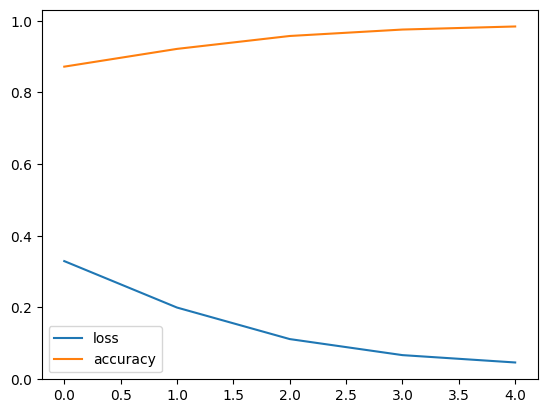

In [32]:
pd.DataFrame(model_history.history).plot()

In [33]:
model.evaluate(val_sequences, val_labels)

258/258 [==============================] - 1s 4ms/step - loss: 0.5239 - accuracy: 0.8899


[0.5239354372024536, 0.889873743057251]

In [40]:
def predict(sentence):
    sequences = tokenizer.texts_to_sequences([sentence])
    padded_sequences = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')
    # get predictions for toxicity
    predictions = model.predict(padded_sequences)
    if model.predict(padded_sequences)[0]<0.5:
        return 'Bad sequence'
    else:
        return 'Normal sequence'

In [41]:
print(predict('I hate you'))

1/1 [==============================] - 0s 18ms/step
Bad sequence


In [42]:
print(predict('I love you'))

1/1 [==============================] - 0s 28ms/step
Normal sequence


In [43]:
import h5py

In [45]:
model.save("/content/drive/MyDrive/DeepLearningl/LiveToxicComment.h5")